# Summary

Milestone 2 of reinforcement learning project. Notebook to understand how GNN work.

## TODO

1. Data representations.
    - Node-level.
    - Edge-level.
2. Create Datasets for corresponding representations.
3. Loss function (distance to identity).
4. Test different networks on each of the datasets.
    - Determine how large they can get.
    - Hyperparameters.
    - Skipping? Residuals?

# Imports/Setup

In [6]:
import torch
from torch_geometric.data import Data
import numpy as np
import scipy.linalg as la
import scipy.sparse.linalg as spla
import scipy 
import scipy.sparse as sp
import matplotlib.pyplot as plt
from torch_geometric.nn import GATConv
import torch.nn as nn

/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /data/users/jupyter-dam724/.local/lib/python3.9/site-packages/libpyg.so: undefined symbol: _ZN3c1010Dispatcher17runRecordFunctionERN2at14RecordFunctionESt17reference_wrapperIKNS_14FunctionSchemaEENS_11DispatchKeyE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while

# Dataset Generation

Helper functions to generate the dataset.

In [7]:
def generate_random_helmholtz(n, density=0.001):
    L = 1.0
    k = np.random.uniform(10, 200)  # Random wavenumber
    h = L / (n - 1)  

    # Discretization of Helmholtz operator (1D)
    diagonals = [np.ones(n-1), -2*np.ones(n), np.ones(n-1)]

    helmholtz = sp.diags(diagonals, [-1, 0, 1]) / h**2 + k**2 * sp.eye(n)

    # Ensure no perturbations on the tridiagnonal
    perturb = sp.random(n, n, density=density) * np.max(helmholtz)
    
    perturb.setdiag(0)  # Main diagonal
    perturb.setdiag(0, k=1)  # First upper diagonal
    perturb.setdiag(0, k=-1)  # First lower diagonal
        
    return helmholtz + perturb

In [8]:
def test_singularity(mat):
    det_mat = np.linalg.det(mat)

    if np.isclose(det_mat, 0):
        print("Matrix is singular.")
        return False
        
    rank_mat = np.linalg.matrix_rank(mat)
    if rank_mat < mat.shape[0]:
        print("Matrix is singular.")
        return False
    
    print("Matrix is non-singular.")
        
    return True

In [9]:
def get_sparsity(mat):
    return ((mat != 0).sum() / (mat.shape[0] * mat.shape[0]))

In [10]:
def get_condition(mat):
    return np.linalg.cond(mat)

*Sanity check 01.*

249001.00000000003 -497532.92430688284
314607.7833167381 -497532.92430688284
18033.971215793612
0.8972000000000001%


/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Matrix is non-singular.


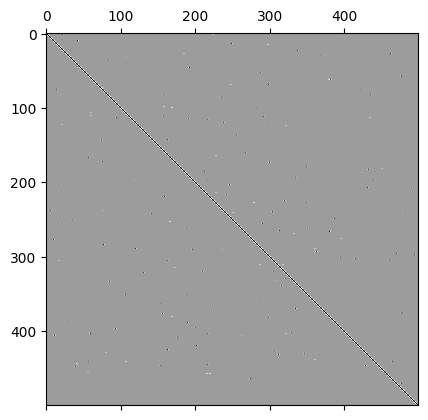

In [11]:
mat = generate_random_helmholtz(500).toarray()
print(mat[0, 1], mat[0, 0])
print(mat.max(), mat.min())

_ = plt.matshow(mat, cmap='gray')
print(get_condition(mat))
print(f'{get_sparsity(mat)*100}%')
_ = test_singularity(mat)

In [7]:
mattorch = torch.from_numpy(mat)

# Data Representation

Different ways to represent data in graphical context.

## Edge List (Adjacency Matrix)

Edge Index: List of the nonzero connections between nodes.

Edge Weights: Weight of the direction node connection.

Uses $\text{dense_to_sparse}(\cdot)$ helper function.

In [8]:
from torch_geometric.utils import dense_to_sparse

In [9]:
edge_index, edge_weights = dense_to_sparse(mattorch)
graph_data_edge = Data(edge_index=edge_index, edge_attr=edge_weights)

In [10]:
print("Edge Index:\n", graph_data_edge.edge_index, graph_data_edge.edge_index.shape)
print("Edge Weights:\n", graph_data_edge.edge_attr, graph_data_edge.edge_attr.shape)

Edge Index:
 tensor([[  0,   0,   1,  ..., 498, 499, 499],
        [  0,   1,   0,  ..., 499, 498, 499]]) torch.Size([2, 2237])
Edge Weights:
 tensor([-497718.3096,  249001.0000,  249001.0000,  ...,  249001.0000,
         249001.0000, -497718.3096], dtype=torch.float64) torch.Size([2237])


## Edge List (Explicit)

Same thing as above but with explicit calculations.

In [11]:
source_nodes, target_nodes = mattorch.nonzero(as_tuple=True)
edge_weights = mattorch[source_nodes, target_nodes]
edge_index = torch.stack([source_nodes, target_nodes], dim=0)

In [12]:
print("Edge Index:\n", edge_index, edge_index.shape)
print("Edge Weights:\n", edge_weights, edge_weights.shape)

Edge Index:
 tensor([[  0,   0,   1,  ..., 498, 499, 499],
        [  0,   1,   0,  ..., 499, 498, 499]]) torch.Size([2, 2237])
Edge Weights:
 tensor([-497718.3096,  249001.0000,  249001.0000,  ...,  249001.0000,
         249001.0000, -497718.3096], dtype=torch.float64) torch.Size([2237])


## Nodes + Edges

Node Feature Vectors: Each column (node) has a corresponding feature vector.

Edge Index: What connects to what.

Edge Weights: The weight of those connections.

In [13]:
node_features = mattorch

In [14]:
source_nodes, target_nodes = mattorch.nonzero(as_tuple=True)
edge_index = torch.stack([source_nodes, target_nodes], dim=0)
edge_weights = mattorch[source_nodes, target_nodes]

In [15]:
graph_data_node_edge = Data(x=node_features, edge_index=edge_index, edge_attr=edge_weights)

In [16]:
print("Node Features:\n", graph_data_node_edge.x, graph_data_node_edge.x.shape)
print("Edge Index:\n", graph_data_node_edge.edge_index, graph_data_node_edge.edge_index.shape)
print("Edge Weights (Edge Attributes):\n", graph_data_node_edge.edge_attr, graph_data_node_edge.edge_attr.shape)

Node Features:
 tensor([[-497718.3096,  249001.0000,       0.0000,  ...,       0.0000,
               0.0000,       0.0000],
        [ 249001.0000, -497718.3096,  249001.0000,  ...,       0.0000,
               0.0000,       0.0000],
        [      0.0000,  249001.0000, -497718.3096,  ...,       0.0000,
               0.0000,       0.0000],
        ...,
        [      0.0000,       0.0000,       0.0000,  ..., -497718.3096,
          249001.0000,       0.0000],
        [      0.0000,       0.0000,       0.0000,  ...,  249001.0000,
         -497718.3096,  249001.0000],
        [      0.0000,       0.0000,       0.0000,  ...,       0.0000,
          249001.0000, -497718.3096]], dtype=torch.float64) torch.Size([500, 500])
Edge Index:
 tensor([[  0,   0,   1,  ..., 498, 499, 499],
        [  0,   1,   0,  ..., 499, 498, 499]]) torch.Size([2, 2237])
Edge Weights (Edge Attributes):
 tensor([-497718.3096,  249001.0000,  249001.0000,  ...,  249001.0000,
         249001.0000, -497718.3096], dtyp

# Graph Datasets

Create multiple datasets to test effectiveness of graph representations.

## Helper Functions

Functions to preprocess data.

In [17]:
def normalize_features(graph_data):
    x_min = graph_data.min()
    x_max = graph_data.max()
    out = (graph_data - x_min) / (x_max - x_min + 1e-8)
    return out.float()

def normalize_edge_attr(graph_data):
    e_min = graph_data.min()
    e_max = graph_data.max()
    out = (graph_data - e_min) / (e_max - e_min + 1e-8)
    return out.float()

In [18]:
normalize_features(graph_data_node_edge.x)

tensor([[0.0000, 1.0000, 0.6665,  ..., 0.6665, 0.6665, 0.6665],
        [1.0000, 0.0000, 1.0000,  ..., 0.6665, 0.6665, 0.6665],
        [0.6665, 1.0000, 0.0000,  ..., 0.6665, 0.6665, 0.6665],
        ...,
        [0.6665, 0.6665, 0.6665,  ..., 0.0000, 1.0000, 0.6665],
        [0.6665, 0.6665, 0.6665,  ..., 1.0000, 0.0000, 1.0000],
        [0.6665, 0.6665, 0.6665,  ..., 0.6665, 1.0000, 0.0000]])

In [19]:
normalize_edge_attr(graph_data_node_edge.edge_attr)

tensor([0., 1., 1.,  ..., 1., 1., 0.])

## *(Edge Only)* Dataset

Dataset to test *(Edge Only)*. Using batching.

*This dataset is not possible from what I have seen. You need some type of node features.*

## *(Edge + Nodes)* Dataset

Dataset to test *(Edge + Nodes)*. Using batching.

In [20]:
from torch_geometric.data import Dataset, Data

In [21]:
class HelmHoltzDataset(Dataset):
    def __init__(self, generator, checker, epoch_len=1000, size=500, density=0.001, transform=None):
        super().__init__(None, transform)
        
        self.epoch_len = epoch_len
        self.mat_size = size
        self.mat_density = density
        
        self.generator = generator
        self.checker = checker

    def len(self):
        return self.epoch_len

    def get(self, idx):
        mat = self.generator(self.mat_size, self.mat_density)
        mat = torch.tensor(mat.toarray(), dtype=torch.float32)
        edge_index, edge_weights = dense_to_sparse(mat)
        
        node_features = normalize_features(mat)
        edge_weights = normalize_edge_attr(edge_weights)

        data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_weights)
        return data

In [22]:
data = HelmHoltzDataset(generate_random_helmholtz, test_singularity)

In [23]:
from torch_geometric.loader import DataLoader

In [24]:
loader = DataLoader(data, batch_size=32)

In [25]:
next(iter(loader))

DataBatch(x=[16000, 500], edge_index=[2, 71732], edge_attr=[71732], batch=[16000], ptr=[33])

# Graph Networks

Trying different types of networks.

### Notes

- Experiment with and w/o "Edge-Attr"

## Graph Convolutional Network (GCN)

Message passing over node features. The **edge-index** and **edge-attr** do not change and indicate strength of the message passing between the nodes.

In [26]:
from torch_geometric.nn import GCNConv

In [27]:
x = normalize_features(graph_data_node_edge.x)
e_ind = graph_data_node_edge.edge_index.int()
e_attr = normalize_edge_attr(graph_data_node_edge.edge_attr)

In [28]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels=500, out_channels=500, l1_lambda=1e-1):
        super().__init__()
        
        self.l1_lambda = l1_lambda

        self.conv1 = GCNConv(in_channels, 100)
        self.conv2 = GCNConv(100, 200)
        self.conv3 = GCNConv(200, out_channels)
        self.tanh = nn.Tanh()
        
    def forward(self, x, edge_index, edge_attr):
        h = self.conv1(x=x, edge_index=edge_index, edge_weight=edge_attr)
        h = self.tanh(h)
        h = self.conv2(x=h, edge_index=edge_index, edge_weight=edge_attr)
        h = self.tanh(h)
        h = self.conv3(x=h, edge_index=edge_index, edge_weight=edge_attr)
        h = self.tanh(h)  
                    
        return h, self.l1_lambda * torch.norm(h, p=1) # l1 regularizaition ? (promote sparsity)

In [29]:
GCN = GCN()

In [30]:
GCN(x, e_ind, e_attr)

(tensor([[-0.1505,  0.0031,  0.3483,  ..., -0.1197,  0.0660,  0.1397],
         [-0.2566, -0.0492,  0.5242,  ..., -0.1865,  0.1203,  0.2568],
         [-0.1825,  0.0077,  0.4129,  ..., -0.1472,  0.0775,  0.1652],
         ...,
         [-0.2362, -0.0124,  0.5150,  ..., -0.1994,  0.1033,  0.2313],
         [-0.2247, -0.0146,  0.4779,  ..., -0.1731,  0.0938,  0.2135],
         [-0.1765, -0.0011,  0.4117,  ..., -0.1467,  0.0810,  0.1655]],
        grad_fn=<TanhBackward0>),
 tensor(5878.4312, grad_fn=<MulBackward0>))

## Graph Attention Network (GAT)

Uses masked self-attention to attend over neighborhood features.

https://pytorch-geometric.readthedocs.io/en/2.5.3/generated/torch_geometric.nn.conv.GATConv.html

In [31]:
from torch_geometric.nn import GATConv

In [32]:
class GAT(nn.Module):
    def __init__(self, in_channels=500, out_channels=500, l1_lambda=1e-1):
        super().__init__()
        
        self.l1_lambda = l1_lambda
        
        self.conv1 = GATConv(in_channels, 100, heads=1, dropout=0.25)
        self.conv2 = GATConv(100, 200, heads=3, dropout=0.25) # (heads * outchannels)
        self.conv3 = GATConv(600, out_channels, heads=1)
        
        self.tanh = nn.Tanh()

    def forward(self, x, edge_index, edge_attr):
        h = self.conv1(x=x, edge_index=edge_index, edge_attr=edge_attr)
        h = self.tanh(h)
        h = self.conv2(x=h, edge_index=edge_index, edge_attr=edge_attr)
        h = self.tanh(h)
        h = self.conv3(x=h, edge_index=edge_index, edge_attr=edge_attr)
        h = self.tanh(h)  
                    
        return h, self.l1_lambda * torch.norm(h, p=1) # l1 regularizaition ? (promote sparsity)

In [33]:
gat = GAT()

In [34]:
gat(x, e_ind.to(torch.int64), e_attr)

(tensor([[ 0.5513,  0.4702, -0.0497,  ...,  0.1431,  0.3386,  0.0225],
         [ 0.5014,  0.4687, -0.0439,  ...,  0.1208,  0.3138,  0.0282],
         [ 0.4409,  0.3958, -0.0648,  ...,  0.1006,  0.3122,  0.0471],
         ...,
         [ 0.4943,  0.4451, -0.1011,  ...,  0.0830,  0.4033,  0.0505],
         [ 0.5626,  0.4753, -0.0975,  ...,  0.1152,  0.4165,  0.0417],
         [ 0.5658,  0.4980, -0.0976,  ...,  0.1117,  0.4253,  0.0425]],
        grad_fn=<TanhBackward0>),
 tensor(5483.5659, grad_fn=<MulBackward0>))

## Graph Transformer (TransformerConv)

Masked label prediction. For some reason the edge weights need to be same size as the output channel size. IDK why.

https://pytorch-geometric.readthedocs.io/en/2.5.1/generated/torch_geometric.nn.conv.TransformerConv.html

In [35]:
from torch_geometric.nn import TransformerConv

In [36]:
class GraphTransformer(nn.Module):
    def __init__(self, in_channels=500, out_channels=500, l1_lambda=1e-1):
        super().__init__()
        
        self.l1_lambda = l1_lambda
        
        self.conv1 = TransformerConv(in_channels, 100, heads=1, dropout=0.25)
        self.conv2 = TransformerConv(100, 200, heads=3, dropout=0.25) # (heads * outchannels)
        self.conv3 = TransformerConv(600, out_channels, heads=1)
        
        self.tanh = nn.Tanh()

    def forward(self, x, edge_index):
        h = self.conv1(x=x, edge_index=edge_index)
        h = self.tanh(h)
        h = self.conv2(x=h, edge_index=edge_index)
        h = self.tanh(h)
        h = self.conv3(x=h, edge_index=edge_index)
        h = self.tanh(h)  
                    
        return h, self.l1_lambda * torch.norm(h, p=1) # l1 regularizaition ? (promote sparsity)

In [37]:
gtransformer = GraphTransformer()

In [38]:
gtransformer(x, e_ind.to(torch.int64))

(tensor([[-0.0121, -0.2640,  0.2482,  ..., -0.0234,  0.2454,  0.4056],
         [-0.0589, -0.2289,  0.1455,  ..., -0.0323,  0.2466,  0.4064],
         [-0.0415, -0.2396,  0.1876,  ..., -0.0927,  0.2082,  0.3812],
         ...,
         [-0.0788, -0.2821,  0.1878,  ..., -0.0781,  0.2541,  0.3757],
         [-0.0502, -0.2519,  0.2017,  ..., -0.0919,  0.2228,  0.4122],
         [-0.0457, -0.2431,  0.2254,  ..., -0.0765,  0.2100,  0.3687]],
        grad_fn=<TanhBackward0>),
 tensor(5234.2593, grad_fn=<MulBackward0>))

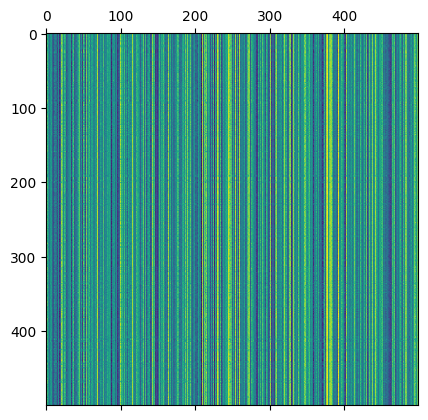

In [39]:
plt.matshow(gtransformer(x, e_ind.to(torch.int64))[0].detach())

In [40]:
torch.norm(torch.matmul(gtransformer(x, e_ind.to(torch.int64))[0], x) - torch.eye(500), p='fro')

tensor(1271.2449, grad_fn=<LinalgVectorNormBackward0>)

## Chebyshev Spectral Graph Convolutional Operator (ChebConv)

Higher-order convolution.

In [41]:
from torch_geometric.nn import ChebConv

In [42]:
class GraphCheb(nn.Module):
    def __init__(self, in_channels=500, out_channels=500, l1_lambda=1e-1):
        super().__init__()
        
        self.l1_lambda = l1_lambda
        
        self.conv1 = ChebConv(in_channels, 100, K=10)
        self.conv2 = ChebConv(100, 200, K=15) # (heads * outchannels)
        self.conv3 = ChebConv(200, out_channels, K=20)
        
        self.tanh = nn.Tanh()

    def forward(self, x, edge_index, edge_attr):
        h = self.conv1(x=x, edge_index=edge_index, edge_weight=edge_attr)
        h = self.tanh(h)
        h = self.conv2(x=h, edge_index=edge_index, edge_weight=edge_attr)
        h = self.tanh(h)
        h = self.conv3(x=h, edge_index=edge_index, edge_weight=edge_attr)
        h = self.tanh(h)  
                    
        return h, self.l1_lambda * torch.norm(h, p=1) # l1 regularizaition ? (promote sparsity)

In [43]:
cheb = GraphCheb()

In [44]:
cheb(x, e_ind.to(torch.int64), e_attr)

(tensor([[ 1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000,  1.0000],
         [ 1.0000, -1.0000, -0.9584,  ..., -1.0000, -1.0000,  1.0000],
         [ 0.9999,  0.4854,  0.9991,  ..., -1.0000, -1.0000,  1.0000],
         ...,
         [-0.9965, -1.0000, -0.9977,  ..., -0.7949, -0.9515,  0.9996],
         [ 0.9995,  1.0000,  0.8914,  ...,  0.9990, -0.7663, -0.9999],
         [ 1.0000,  1.0000,  0.9996,  ...,  0.9978, -0.9968, -0.9991]],
        grad_fn=<TanhBackward0>),
 tensor(22693.1016, grad_fn=<MulBackward0>))

## Tesing Loader

This loader has batched input. Batching is a little weird but it works for this context because (e.g. 500 never touches 500+ meaning the node and its resulting embedding is limited to the message passing it recieves).

In [45]:
d = next(iter(loader))

In [46]:
o = gat(d.x, d.edge_index, d.edge_attr)
i = gtransformer(d.x, d.edge_index)

In [47]:
o[0].shape, i[0].shape

(torch.Size([16000, 500]), torch.Size([16000, 500]))

# Objectives

Loss functions.

In [55]:
def eye_dist(inp, outp, l1_loss, batch_size=32):
    
    for i in range(inp.ptr.shape[0] - 1):
        start, end = inp.ptr[i], inp.ptr[i + 1] 
        inner_product = torch.matmul(inp.x[start:end], outp[start:end])  
        frobenius_loss = torch.norm(inner_product - torch.eye(500), p='fro')
    
    return frobenius_loss + l1_loss

In [73]:
loss = eye_dist(d, i[0], i[1])

# Training GNNs

Space to test the training pipelines.

## Sanity Check 01

In [55]:
import torch.optim as optim

In [59]:
optimizer = optim.Adam(gtransformer.parameters(), lr=0.001)
criterion = eye_dist

batch = next(iter(loader))

output, l1 = gtransformer(batch.x, batch.edge_index)
loss = criterion(batch, output, l1)

optimizer.zero_grad() 
loss.backward()
optimizer.step()

## Training Pipeline

Test training pipeline uses use the eye_dist.

In [60]:
from tqdm.notebook import tqdm

In [61]:
optimizer = optim.Adam(gtransformer.parameters(), lr=0.001)
criterion = eye_dist
epoches = 1

for epoch in range(epoches):
    t_loader = tqdm(loader, desc=f'Train', leave=False, mininterval=2.0)
    for batch in t_loader:
        output, l1 = gtransformer(batch.x, batch.edge_index)
        loss = criterion(batch, output, l1)
        
        t_loader.set_postfix(train_loss=loss.item())

        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

Train:   0%|          | 0/32 [00:00<?, ?it/s]

In [62]:
data = HelmHoltzDataset(generate_random_helmholtz, test_singularity)
data = data.get(0)

out = gtransformer(data.x, data.edge_index)
torch.norm(torch.matmul(out[0], data.x) - torch.eye(500), p='fro')

tensor(127.9844, grad_fn=<LinalgVectorNormBackward0>)

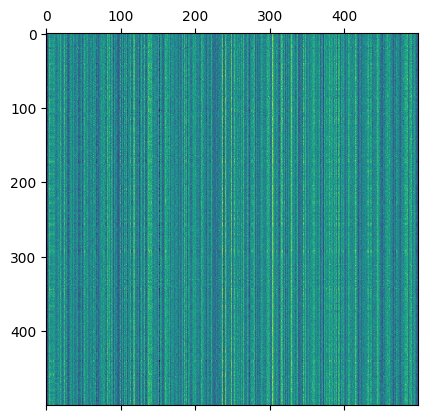

In [63]:
plt.matshow(out[0].detach())